# Method 5 - Best Ideas High Minus Low Focus

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Focus

focus = inst_data.groupby(['datadate', 'institution_id'])['fsym_id'].count().rename('focus').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Focus

best_ideas = best_ideas.merge(focus)
best_ideas['focus_pct'] = best_ideas.groupby('datadate')['focus'].rank(pct=True)
low_ideas = best_ideas[best_ideas['focus_pct'] < (1 / 3)]
high_ideas = best_ideas[best_ideas['focus_pct'] > (2 / 3)]

# Weight the best ideas equally

low_ideas['target'] = 1 / low_ideas.groupby('datadate')['institution_id'].transform('count')
high_ideas['target'] = 1 / high_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
low_w = weights.Weights(low_ideas)
high_w = weights.Weights(high_ideas)

%store -r r

low_p = portfolio.DailyPortfolio(low_w, r, end_date='2018-12-31')
high_p = portfolio.DailyPortfolio(high_w, r, end_date='2018-12-31')

monthly_return = (high_p.port_return - low_p.port_return).loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return.name = 'port_return'

## Plot Performance

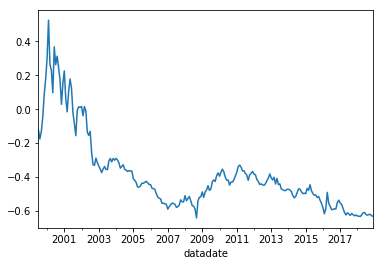

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.177114
2000-12-31   -0.022304
2001-12-31   -0.122203
2002-12-31   -0.322760
2003-12-31    0.021391
2004-12-31   -0.090634
2005-12-31   -0.126139
2006-12-31   -0.209620
2007-12-31    0.033143
2008-12-31    0.065750
2009-12-31    0.291202
2010-12-31   -0.031009
2011-12-31    0.045827
2012-12-31   -0.022875
2013-12-31   -0.146710
2014-12-31   -0.043539
2015-12-31   -0.119315
2016-12-31    0.042968
2017-12-31   -0.189501
2018-12-31   -0.024339
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     16.91
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.67e-12
Time:                        05:32:54   Log-Likelihood:                 361.94
No. Observations:                 234   AIC:                            -713.9
Df Residuals:                     229   BIC:                            -696.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.004     -0.331      0.741      -0.008       0.006
mktrf          0.0457      0.097      0.471      0.638      -0.146       0.237
me             0.3124      0.113      2.765      0.006       0.090       0.535
ia            -0.2658      0.172     -1.548      0.123      -0.604       0.073
roe           -0.6346      0.147     -4.317      0.000      -0.924      -0.345
==============================================================================
Omnibus:                      118.791   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1033.369
Skew:                           1.787   Prob(JB):                    4.04e-225
Kurtosis:                      12.655   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     10.53
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.51e-08
Time:                        05:32:54   Log-Likelihood:                 361.94
No. Observations:                 234   AIC:                            -713.9
Df Residuals:                     229   BIC:                            -696.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.003     -0.348      0.728      -0.008       0.005
mktrf          0.0457      0.186      0.246      0.806      -0.319       0.410
me             0.3124      0.194      1.609      0.108      -0.068       0.693
ia            -0.2658      0.225     -1.182      0.237      -0.706       0.175
roe           -0.6346      0.159     -4.002      0.000      -0.945      -0.324
==============================================================================
Omnibus:                      118.791   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1033.369
Skew:                           1.787   Prob(JB):                    4.04e-225
Kurtosis:                      12.655   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.228
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     11.60
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.36e-08
Time:                        05:32:55   Log-Likelihood:                 361.94
No. Observations:                 234   AIC:                            -713.9
Df Residuals:                     229   BIC:                            -696.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0012      0.003     -0.338      0.735      -0.008       0.006
mktrf          0.0457      0.177      0.259      0.796      -0.301       0.392
me             0.3124      0.201      1.555      0.120      -0.081       0.706
ia            -0.2658      0.255     -1.042      0.298      -0.766       0.234
roe           -0.6346      0.159     -3.997      0.000      -0.946      -0.323
==============================================================================
Omnibus:                      118.791   Durbin-Watson:                   2.048
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1033.369
Skew:                           1.787   Prob(JB):                    4.04e-225
Kurtosis:                      12.655   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     20.99
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.05e-17
Time:                        05:32:55   Log-Likelihood:                 375.96
No. Observations:                 234   AIC:                            -739.9
Df Residuals:                     228   BIC:                            -719.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.003     -0.117      0.907      -0.007       0.006
mktrf          0.0809      0.092      0.881      0.379      -0.100       0.262
smb            0.1789      0.121      1.475      0.141      -0.060       0.418
hml           -0.2607      0.143     -1.824      0.069      -0.542       0.021
rmw           -0.8775      0.162     -5.430      0.000      -1.196      -0.559
cma            0.3039      0.205      1.479      0.140      -0.101       0.709
==============================================================================
Omnibus:                      114.231   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              973.502
Skew:                           1.705   Prob(JB):                    4.04e-212
Kurtosis:                      12.393   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     21.42
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.50e-17
Time:                        05:32:55   Log-Likelihood:                 375.96
No. Observations:                 234   AIC:                            -739.9
Df Residuals:                     228   BIC:                            -719.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.003     -0.117      0.907      -0.007       0.006
mktrf          0.0809      0.119      0.678      0.498      -0.153       0.315
smb            0.1789      0.132      1.356      0.175      -0.080       0.437
hml           -0.2607      0.226     -1.155      0.248      -0.703       0.182
rmw           -0.8775      0.139     -6.293      0.000      -1.151      -0.604
cma            0.3039      0.211      1.444      0.149      -0.109       0.716
==============================================================================
Omnibus:                      114.231   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              973.502
Skew:                           1.705   Prob(JB):                    4.04e-212
Kurtosis:                      12.393   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.315
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     20.85
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.86e-17
Time:                        05:32:55   Log-Likelihood:                 375.96
No. Observations:                 234   AIC:                            -739.9
Df Residuals:                     228   BIC:                            -719.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.004     -0.108      0.914      -0.008       0.007
mktrf          0.0809      0.116      0.696      0.486      -0.147       0.309
smb            0.1789      0.138      1.297      0.195      -0.091       0.449
hml           -0.2607      0.221     -1.180      0.238      -0.694       0.172
rmw           -0.8775      0.150     -5.863      0.000      -1.171      -0.584
cma            0.3039      0.186      1.635      0.102      -0.060       0.668
==============================================================================
Omnibus:                      114.231   Durbin-Watson:                   1.923
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              973.502
Skew:                           1.705   Prob(JB):                    4.04e-212
Kurtosis:                      12.393   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     18.63
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.84e-13
Time:                        05:32:55   Log-Likelihood:                 364.63
No. Observations:                 234   AIC:                            -719.3
Df Residuals:                     229   BIC:                            -702.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.003     -1.140      0.256      -0.011       0.003
mktrf          0.2120      0.088      2.398      0.017       0.038       0.386
smb            0.5861      0.110      5.311      0.000       0.369       0.804
hml           -0.3498      0.110     -3.191      0.002      -0.566      -0.134
umd           -0.1100      0.072     -1.529      0.128      -0.252       0.032
==============================================================================
Omnibus:                      117.074   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              973.004
Skew:                           1.771   Prob(JB):                    5.19e-212
Kurtosis:                      12.341   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     10.70
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.71e-08
Time:                        05:32:55   Log-Likelihood:                 364.63
No. Observations:                 234   AIC:                            -719.3
Df Residuals:                     229   BIC:                            -702.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.003     -1.282      0.200      -0.010       0.002
mktrf          0.2120      0.148      1.430      0.153      -0.079       0.503
smb            0.5861      0.146      4.006      0.000       0.299       0.873
hml           -0.3498      0.178     -1.963      0.050      -0.699      -0.000
umd           -0.1100      0.084     -1.304      0.192      -0.275       0.055
==============================================================================
Omnibus:                      117.074   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              973.004
Skew:                           1.771   Prob(JB):                    5.19e-212
Kurtosis:                      12.341   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.246
Model:                            OLS   Adj. R-squared:                  0.232
Method:                 Least Squares   F-statistic:                     12.80
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.03e-09
Time:                        05:32:55   Log-Likelihood:                 364.63
No. Observations:                 234   AIC:                            -719.3
Df Residuals:                     229   BIC:                            -702.0
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0039      0.003     -1.221      0.222      -0.010       0.002
mktrf          0.2120      0.148      1.432      0.152      -0.078       0.502
smb            0.5861      0.137      4.280      0.000       0.318       0.854
hml           -0.3498      0.191     -1.832      0.067      -0.724       0.024
umd           -0.1100      0.088     -1.257      0.209      -0.282       0.062
==============================================================================
Omnibus:                      117.074   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              973.004
Skew:                           1.771   Prob(JB):                    5.19e-212
Kurtosis:                      12.341   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     10.59
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.44e-07
Time:                        05:32:55   Log-Likelihood:                 166.77
No. Observations:                 120   AIC:                            -323.5
Df Residuals:                     115   BIC:                            -309.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.006     -0.066      0.948      -0.012       0.011
mktrf         -0.0744      0.159     -0.469      0.640      -0.389       0.240
me             0.3582      0.157      2.285      0.024       0.048       0.669
ia            -0.6847      0.245     -2.789      0.006      -1.171      -0.198
roe           -0.5552      0.217     -2.555      0.012      -0.986      -0.125
==============================================================================
Omnibus:                       59.186   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              277.015
Skew:                           1.642   Prob(JB):                     7.03e-61
Kurtosis:                       9.679   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     15.53
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.48e-10
Time:                        05:32:55   Log-Likelihood:                 166.77
No. Observations:                 120   AIC:                            -323.5
Df Residuals:                     115   BIC:                            -309.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.005     -0.079      0.937      -0.010       0.009
mktrf         -0.0744      0.313     -0.237      0.812      -0.689       0.540
me             0.3582      0.235      1.525      0.127      -0.102       0.819
ia            -0.6847      0.261     -2.626      0.009      -1.196      -0.174
roe           -0.5552      0.223     -2.487      0.013      -0.993      -0.118
==============================================================================
Omnibus:                       59.186   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              277.015
Skew:                           1.642   Prob(JB):                     7.03e-61
Kurtosis:                       9.679   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     37.87
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.49e-20
Time:                        05:32:55   Log-Likelihood:                 166.77
No. Observations:                 120   AIC:                            -323.5
Df Residuals:                     115   BIC:                            -309.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.005     -0.079      0.937      -0.010       0.009
mktrf         -0.0744      0.309     -0.241      0.810      -0.679       0.531
me             0.3582      0.248      1.445      0.148      -0.128       0.844
ia            -0.6847      0.261     -2.625      0.009      -1.196      -0.174
roe           -0.5552      0.223     -2.487      0.013      -0.993      -0.118
==============================================================================
Omnibus:                       59.186   Durbin-Watson:                   2.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              277.015
Skew:                           1.642   Prob(JB):                     7.03e-61
Kurtosis:                       9.679   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     16.16
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.06e-12
Time:                        05:32:55   Log-Likelihood:                 180.10
No. Observations:                 120   AIC:                            -348.2
Df Residuals:                     114   BIC:                            -331.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.005      0.304      0.762      -0.009       0.012
mktrf          0.0297      0.150      0.197      0.844      -0.268       0.328
smb            0.2258      0.170      1.325      0.188      -0.112       0.563
hml           -0.6265      0.209     -3.001      0.003      -1.040      -0.213
rmw           -0.6409      0.246     -2.603      0.010      -1.129      -0.153
cma            0.2131      0.270      0.790      0.431      -0.321       0.747
==============================================================================
Omnibus:                       54.643   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              270.936
Skew:                           1.460   Prob(JB):                     1.47e-59
Kurtosis:                       9.757   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     42.66
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.39e-24
Time:                        05:32:55   Log-Likelihood:                 180.10
No. Observations:                 120   AIC:                            -348.2
Df Residuals:                     114   BIC:                            -331.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.005      0.304      0.761      -0.009       0.012
mktrf          0.0297      0.204      0.146      0.884      -0.369       0.429
smb            0.2258      0.186      1.213      0.225      -0.139       0.591
hml           -0.6265      0.186     -3.377      0.001      -0.990      -0.263
rmw           -0.6409      0.202     -3.169      0.002      -1.037      -0.245
cma            0.2131      0.219      0.972      0.331      -0.216       0.643
==============================================================================
Omnibus:                       54.643   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              270.936
Skew:                           1.460   Prob(JB):                     1.47e-59
Kurtosis:                       9.757   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.415
Model:                            OLS   Adj. R-squared:                  0.389
Method:                 Least Squares   F-statistic:                     76.59
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.14e-35
Time:                        05:32:55   Log-Likelihood:                 180.10
No. Observations:                 120   AIC:                            -348.2
Df Residuals:                     114   BIC:                            -331.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0016      0.006      0.283      0.777      -0.010       0.013
mktrf          0.0297      0.201      0.148      0.883      -0.364       0.423
smb            0.2258      0.187      1.206      0.228      -0.141       0.593
hml           -0.6265      0.161     -3.883      0.000      -0.943      -0.310
rmw           -0.6409      0.215     -2.976      0.003      -1.063      -0.219
cma            0.2131      0.179      1.194      0.233      -0.137       0.563
==============================================================================
Omnibus:                       54.643   Durbin-Watson:                   1.871
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              270.936
Skew:                           1.460   Prob(JB):                     1.47e-59
Kurtosis:                       9.757   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     18.23
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.27e-11
Time:                        05:32:55   Log-Likelihood:                 177.42
No. Observations:                 120   AIC:                            -344.8
Df Residuals:                     115   BIC:                            -330.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.005     -0.322      0.748      -0.012       0.009
mktrf          0.1574      0.128      1.230      0.221      -0.096       0.411
smb            0.5383      0.146      3.695      0.000       0.250       0.827
hml           -0.7134      0.146     -4.889      0.000      -1.002      -0.424
umd           -0.0785      0.090     -0.872      0.385      -0.257       0.100
==============================================================================
Omnibus:                       61.081   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              342.560
Skew:                           1.624   Prob(JB):                     4.11e-75
Kurtosis:                      10.614   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     23.87
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.18e-14
Time:                        05:32:55   Log-Likelihood:                 177.42
No. Observations:                 120   AIC:                            -344.8
Df Residuals:                     115   BIC:                            -330.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.004     -0.389      0.697      -0.010       0.007
mktrf          0.1574      0.206      0.763      0.446      -0.247       0.562
smb            0.5383      0.125      4.308      0.000       0.293       0.783
hml           -0.7134      0.163     -4.370      0.000      -1.033      -0.393
umd           -0.0785      0.103     -0.759      0.448      -0.281       0.124
==============================================================================
Omnibus:                       61.081   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              342.560
Skew:                           1.624   Prob(JB):                     4.11e-75
Kurtosis:                      10.614   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.388
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     42.77
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.18e-22
Time:                        05:32:55   Log-Likelihood:                 177.42
No. Observations:                 120   AIC:                            -344.8
Df Residuals:                     115   BIC:                            -330.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0017      0.005     -0.369      0.712      -0.011       0.007
mktrf          0.1574      0.204      0.772      0.440      -0.242       0.557
smb            0.5383      0.095      5.669      0.000       0.352       0.724
hml           -0.7134      0.124     -5.737      0.000      -0.957      -0.470
umd           -0.0785      0.108     -0.724      0.469      -0.291       0.134
==============================================================================
Omnibus:                       61.081   Durbin-Watson:                   1.949
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              342.560
Skew:                           1.624   Prob(JB):                     4.11e-75
Kurtosis:                      10.614   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     11.45
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.54e-08
Time:                        05:32:55   Log-Likelihood:                 217.71
No. Observations:                 114   AIC:                            -425.4
Df Residuals:                     109   BIC:                            -411.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.004     -0.859      0.392      -0.010       0.004
mktrf          0.2180      0.108      2.023      0.046       0.004       0.432
me             0.0585      0.166      0.351      0.726      -0.271       0.388
ia             0.6121      0.231      2.652      0.009       0.155       1.069
roe           -0.8212      0.203     -4.050      0.000      -1.223      -0.419
==============================================================================
Omnibus:                       19.444   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.488
Skew:                           0.519   Prob(JB):                     5.42e-13
Kurtosis:                       6.289   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     13.84
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.69e-09
Time:                        05:32:55   Log-Likelihood:                 217.71
No. Observations:                 114   AIC:                            -425.4
Df Residuals:                     109   BIC:                            -411.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.003     -1.125      0.260      -0.009       0.002
mktrf          0.2180      0.090      2.419      0.016       0.041       0.395
me             0.0585      0.225      0.260      0.795      -0.382       0.499
ia             0.6121      0.238      2.575      0.010       0.146       1.078
roe           -0.8212      0.424     -1.936      0.053      -1.653       0.010
==============================================================================
Omnibus:                       19.444   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.488
Skew:                           0.519   Prob(JB):                     5.42e-13
Kurtosis:                       6.289   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.296
Model:                            OLS   Adj. R-squared:                  0.270
Method:                 Least Squares   F-statistic:                     17.24
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.50e-11
Time:                        05:32:55   Log-Likelihood:                 217.71
No. Observations:                 114   AIC:                            -425.4
Df Residuals:                     109   BIC:                            -411.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0031      0.002     -1.311      0.190      -0.008       0.002
mktrf          0.2180      0.087      2.513      0.012       0.048       0.388
me             0.0585      0.247      0.237      0.813      -0.426       0.543
ia             0.6121      0.254      2.412      0.016       0.115       1.109
roe           -0.8212      0.426     -1.927      0.054      -1.657       0.014
==============================================================================
Omnibus:                       19.444   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               56.488
Skew:                           0.519   Prob(JB):                     5.42e-13
Kurtosis:                       6.289   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     10.19
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.12e-08
Time:                        05:32:55   Log-Likelihood:                 219.75
No. Observations:                 114   AIC:                            -427.5
Df Residuals:                     108   BIC:                            -411.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.004     -1.057      0.293      -0.011       0.003
mktrf          0.2236      0.101      2.205      0.030       0.023       0.425
smb            0.0206      0.165      0.125      0.901      -0.306       0.347
hml            0.5329      0.210      2.538      0.013       0.117       0.949
rmw           -0.6703      0.257     -2.607      0.010      -1.180      -0.161
cma            0.2921      0.326      0.895      0.373      -0.355       0.939
==============================================================================
Omnibus:                       40.495   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              238.626
Skew:                           0.970   Prob(JB):                     1.52e-52
Kurtosis:                       9.817   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     9.712
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.11e-07
Time:                        05:32:55   Log-Likelihood:                 219.75
No. Observations:                 114   AIC:                            -427.5
Df Residuals:                     108   BIC:                            -411.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.003     -1.288      0.198      -0.010       0.002
mktrf          0.2236      0.074      3.005      0.003       0.078       0.369
smb            0.0206      0.162      0.127      0.899      -0.296       0.338
hml            0.5329      0.165      3.239      0.001       0.210       0.855
rmw           -0.6703      0.304     -2.205      0.027      -1.266      -0.074
cma            0.2921      0.231      1.263      0.207      -0.161       0.745
==============================================================================
Omnibus:                       40.495   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              238.626
Skew:                           0.970   Prob(JB):                     1.52e-52
Kurtosis:                       9.817   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.321
Model:                            OLS   Adj. R-squared:                  0.289
Method:                 Least Squares   F-statistic:                     10.67
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.38e-08
Time:                        05:32:55   Log-Likelihood:                 219.75
No. Observations:                 114   AIC:                            -427.5
Df Residuals:                     108   BIC:                            -411.1
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0038      0.003     -1.451      0.147      -0.009       0.001
mktrf          0.2236      0.080      2.783      0.005       0.066       0.381
smb            0.0206      0.183      0.112      0.911      -0.339       0.380
hml            0.5329      0.178      2.987      0.003       0.183       0.883
rmw           -0.6703      0.300     -2.231      0.026      -1.259      -0.081
cma            0.2921      0.196      1.492      0.136      -0.092       0.676
==============================================================================
Omnibus:                       40.495   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              238.626
Skew:                           0.970   Prob(JB):                     1.52e-52
Kurtosis:                       9.817   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     10.70
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.37e-07
Time:                        05:32:55   Log-Likelihood:                 216.60
No. Observations:                 114   AIC:                            -423.2
Df Residuals:                     109   BIC:                            -409.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.004     -1.170      0.245      -0.012       0.003
mktrf          0.2489      0.103      2.414      0.017       0.045       0.453
smb            0.1656      0.161      1.030      0.305      -0.153       0.484
hml            0.6744      0.166      4.072      0.000       0.346       1.003
umd           -0.1242      0.125     -0.994      0.322      -0.372       0.123
==============================================================================
Omnibus:                       45.735   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.869
Skew:                           1.095   Prob(JB):                     6.29e-67
Kurtosis:                      10.706   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     12.16
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.31e-08
Time:                        05:32:55   Log-Likelihood:                 216.60
No. Observations:                 114   AIC:                            -423.2
Df Residuals:                     109   BIC:                            -409.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.003     -1.442      0.149      -0.010       0.002
mktrf          0.2489      0.081      3.086      0.002       0.091       0.407
smb            0.1656      0.159      1.039      0.299      -0.147       0.478
hml            0.6744      0.171      3.941      0.000       0.339       1.010
umd           -0.1242      0.108     -1.146      0.252      -0.337       0.088
==============================================================================
Omnibus:                       45.735   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.869
Skew:                           1.095   Prob(JB):                     6.29e-67
Kurtosis:                      10.706   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.282
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                     13.28
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.55e-09
Time:                        05:32:55   Log-Likelihood:                 216.60
No. Observations:                 114   AIC:                            -423.2
Df Residuals:                     109   BIC:                            -409.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.003     -1.642      0.101      -0.009       0.001
mktrf          0.2489      0.088      2.832      0.005       0.077       0.421
smb            0.1656      0.164      1.009      0.313      -0.156       0.487
hml            0.6744      0.187      3.609      0.000       0.308       1.041
umd           -0.1242      0.111     -1.121      0.262      -0.341       0.093
==============================================================================
Omnibus:                       45.735   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              304.869
Skew:                           1.095   Prob(JB):                     6.29e-67
Kurtosis:                      10.706   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""